# Semi-Supervised Learning

## 필수 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, accuracy_score,f1_score
import seaborn as sns

## 데이터 불러오기
- natural-classifier를 통해 전처리된 csv를 df로 불러옴

In [2]:
labeled_df = pd.read_csv("./data/labeled.csv", index_col=0)
unlabeled_df = pd.read_csv("./data/emotion_un-labeled_ETRI.csv", index_col=0)

print(labeled_df.shape, unlabeled_df.shape)

(1354, 9) (12461, 8)


## 데이터 전처리

In [3]:
X= labeled_df.iloc[:,2:]
y = labeled_df.iloc[:,0]

print(X.shape, y.shape)

(1354, 7) (1354,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1083, 7) (1083,)
(271, 7) (271,)


In [5]:
X_train_label = X_train
y_train_label = y_train
X_test_label = X_test
y_test_label = y_test
without_label = unlabeled_df.iloc[:,1:]

print(without_label.shape)

(12461, 7)


## Semi-Supervised Model 학습
- 이전 코드를 통해 선정된 최고 성능의 binary classifier & parameters 

In [6]:
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix

def evaluation(y_true,y_pred):
    print("Accuracy: {:.2f}".format(accuracy_score(y_true,y_pred)))
    print("Precision: {:.2f}".format(precision_score(y_true,y_pred)))
    print("Recall: {:.2f}".format(recall_score(y_true,y_pred)))
    print(roc_auc_score(y_true,y_pred))
    print(f1_score(y_true,y_pred))
    print(confusion_matrix(y_true,y_pred))

In [7]:
def confident_prediction(df):
    result = []

    for i in range(len(df)):
        if df[i][0] >= df[i][1]:
            result.append(df[i][0])
        else:
            result.append(df[i][1])
    return result    

In [8]:
#model에 대한 라이브러리 추가
from sklearn.ensemble import RandomForestClassifier

In [24]:
import time
# hyper parameters
PERCENTAGE = 5
UNLABELED_USAGE = 80  #unlabeled 데이터 중 사용할 데이터 %

#total_unlabeled는 라벨이 없는 데이터의 총 개수
# unlabeled 데이터의 n%만을 사용한다. (진짜 confidence가 낮은 10%는 학습에서 제외하자는 의도)
# num_left_unlabeled에는 unlabeled 중에서 준지도 학습이 종료되고 남을 데이터의 개수가 저장됨.
total_unlabeled = without_label.shape[0]
num_left_unlabeled = int(without_label.shape[0]*(100-UNLABELED_USAGE)*0.01)

#Semi-Supervised Learning
cycle_cnt = 0
conf_list = []
finish = False
while True:
    # 성능 향상없이 무한으로 반복되는 경우를 방지하기 위해 최대 1000번의 cycle수를 제한한다.
    if cycle_cnt == 1000:
        print(f"!!! approach limit {cycle_cnt} !!!")
        finish = True
    cycle_cnt += 1
    # 반복문을 돌며 without_label을 소비하게 되고,
    # without_label의 데이터 수가 남기고 싶은 테이터 수보다 작아질 때까지 학습한다.
    if without_label.shape[0] >= num_left_unlabeled and finish==False:
        print(f"\n===== {cycle_cnt} cycle =====")
        ### modify model & parameters ###
        model = RandomForestClassifier()
        ##################################
        model.fit(X_train_label,y_train_label)
        y_pred_label = model.predict(X_test_label)
        evaluation(y_test_label, y_pred_label)

        #unlabeled 데이터에 대한 예측
        prob = model.predict_proba(without_label) ##양품인지 불량품인지 예측확률
        confident_prob = confident_prediction(prob) #예측확률 값을 대입.
        without_label['confidence'] = confident_prob ##새로운 칼럼 생성

        #내림차순 정렬
        without_label = without_label.sort_values(by=['confidence'],ascending=False) #신뢰도 내림차순 정렬
        without_label = without_label.reset_index(drop=True) #index도 다시 정렬
        length = without_label.shape[0] #unlabeled 행의 개수
        cutting_index = int(length*(PERCENTAGE*0.01)) #남은 unlabeled의 confidence 상위 5%
        #해당 과정을 통해 어느정도 신뢰도에서 예측된 값이 라벨링되는지 파악 가능.
        one_cycle_last_conf = without_label['confidence'][cutting_index]
        conf_list.append(one_cycle_last_conf)
        print(f"threshold confidence : {without_label['confidence'][cutting_index]}")
        chosen_without_label = without_label.iloc[:cutting_index, :] #상위 10%
        chosen_without_label = chosen_without_label.drop(columns={'confidence'})
        notchosen_without_label = without_label.iloc[cutting_index:, :] #하위 95%
        notchosen_without_label = notchosen_without_label.drop(columns={'confidence'})
        pseudo_label = pd.DataFrame(model.predict(chosen_without_label)) #상위 5% 데이터를 통한 예측 값을 새로운 df에 저장

        # 이 과정은 기존 label 데이터로 학습했을 때, 성능이 80%로 준수했기에 가능한 절차이다.
        X_train_label = pd.concat([X_train_label, chosen_without_label])#기존 label의 X에 unlabeled 중 상위 10%의 X를 합침
        y_train_label = pd.concat([y_train_label, pseudo_label])        #기존 label에 unlabeled 중 상위 10%의 예측 label을 합침
        without_label = notchosen_without_label                       #하위 95%의 데이터는 다시 with_label로 저장되어 semi-supervised learning 진행
        y_pred_label = model.predict(X_test_label) 
        evaluation(y_test_label, y_pred_label)
        # time.sleep(1)
    else:
        print()
        #unlabeled data 총 개수 / 남은 데이터 수 = 사용한 데이터 수(%)
        using_unlabeled = total_unlabeled-without_label.shape[0]
        print(f"ALL DONE, UNLABELED LEARNING USED: {using_unlabeled}({(100*using_unlabeled)//total_unlabeled}%).")
        print(f"AVERAGE CONFIDENCE: {np.mean(conf_list)}")
        break



===== 1 cycle =====
Accuracy: 0.81
Precision: 0.78
Recall: 0.87
0.8078976034858388
0.8194444444444444
[[101  34]
 [ 18 118]]
threshold confidence : 1.0
Accuracy: 0.81
Precision: 0.78
Recall: 0.87
0.8078976034858388
0.8194444444444444
[[101  34]
 [ 18 118]]

===== 2 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.77
Recall: 0.87
0.8041938997821351
0.8166089965397925
[[100  35]
 [ 18 118]]
threshold confidence : 1.0
Accuracy: 0.80
Precision: 0.77
Recall: 0.87
0.8041938997821351
0.8166089965397925
[[100  35]
 [ 18 118]]

===== 3 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8078703703703703
0.8206896551724138
[[100  35]
 [ 17 119]]
threshold confidence : 1.0
Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8078703703703703
0.8206896551724138
[[100  35]
 [ 17 119]]

===== 4 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]
threshold confidence : 1.0
Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]

===== 5 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.77
Recall: 0.87
0.8041938997821351
0.8166089965397925
[[100  35]
 [ 18 118]]
threshold confidence : 1.0
Accuracy: 0.80
Precision: 0.77
Recall: 0.87
0.8041938997821351
0.8166089965397925
[[100  35]
 [ 18 118]]

===== 6 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.88
0.8115740740740741
0.823529411764706
[[101  34]
 [ 17 119]]
threshold confidence : 1.0
Accuracy: 0.81
Precision: 0.78
Recall: 0.88
0.8115740740740741
0.823529411764706
[[101  34]
 [ 17 119]]

===== 7 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.76
Recall: 0.88
0.8041394335511982
0.8191126279863482
[[ 98  37]
 [ 16 120]]
threshold confidence : 1.0
Accuracy: 0.80
Precision: 0.76
Recall: 0.88
0.8041394335511982
0.8191126279863482
[[ 98  37]
 [ 16 120]]

===== 8 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.76
Recall: 0.86
0.7968137254901961
0.8096885813148789
[[ 99  36]
 [ 19 117]]
threshold confidence : 1.0
Accuracy: 0.80
Precision: 0.76
Recall: 0.86
0.7968137254901961
0.8096885813148789
[[ 99  36]
 [ 19 117]]

===== 9 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.76
Recall: 0.88
0.8004629629629629
0.8150684931506849
[[ 98  37]
 [ 17 119]]
threshold confidence : 1.0
Accuracy: 0.80
Precision: 0.76
Recall: 0.88
0.8004629629629629
0.8150684931506849
[[ 98  37]
 [ 17 119]]

===== 10 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.76
Recall: 0.88
0.8004629629629629
0.8150684931506849
[[ 98  37]
 [ 17 119]]
threshold confidence : 1.0
Accuracy: 0.80
Precision: 0.76
Recall: 0.88
0.8004629629629629
0.8150684931506849
[[ 98  37]
 [ 17 119]]

===== 11 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8078703703703703
0.8206896551724138
[[100  35]
 [ 17 119]]
threshold confidence : 1.0
Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8078703703703703
0.8206896551724138
[[100  35]
 [ 17 119]]

===== 12 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.83
Precision: 0.79
Recall: 0.89
0.826334422657952
0.8373702422145328
[[103  32]
 [ 15 121]]
threshold confidence : 1.0
Accuracy: 0.83
Precision: 0.79
Recall: 0.89
0.826334422657952
0.8373702422145328
[[103  32]
 [ 15 121]]

===== 13 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.86
0.8079248366013072
0.8181818181818182
[[102  33]
 [ 19 117]]
threshold confidence : 1.0
Accuracy: 0.81
Precision: 0.78
Recall: 0.86
0.8079248366013072
0.8181818181818182
[[102  33]
 [ 19 117]]

===== 14 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152777777777777
0.826388888888889
[[102  33]
 [ 17 119]]
threshold confidence : 1.0
Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152777777777777
0.826388888888889
[[102  33]
 [ 17 119]]

===== 15 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.78
Recall: 0.85
0.8042483660130719
0.8140350877192983
[[102  33]
 [ 20 116]]
threshold confidence : 0.99
Accuracy: 0.80
Precision: 0.78
Recall: 0.85
0.8042483660130719
0.8140350877192983
[[102  33]
 [ 20 116]]

===== 16 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.80
Precision: 0.77
Recall: 0.87
0.8041938997821351
0.8166089965397925
[[100  35]
 [ 18 118]]
threshold confidence : 0.97
Accuracy: 0.80
Precision: 0.77
Recall: 0.87
0.8041938997821351
0.8166089965397925
[[100  35]
 [ 18 118]]

===== 17 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8115468409586056
0.8247422680412372
[[100  35]
 [ 16 120]]
threshold confidence : 0.99
Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8115468409586056
0.8247422680412372
[[100  35]
 [ 16 120]]

===== 18 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.87
0.8116013071895425
0.8222996515679443
[[102  33]
 [ 18 118]]
threshold confidence : 0.99
Accuracy: 0.81
Precision: 0.78
Recall: 0.87
0.8116013071895425
0.8222996515679443
[[102  33]
 [ 18 118]]

===== 19 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]
threshold confidence : 0.99
Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]

===== 20 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8189542483660129
0.8304498269896193
[[102  33]
 [ 16 120]]
threshold confidence : 1.0
Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8189542483660129
0.8304498269896193
[[102  33]
 [ 16 120]]

===== 21 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.89
0.8152233115468409
0.8287671232876713
[[100  35]
 [ 15 121]]
threshold confidence : 0.99
Accuracy: 0.82
Precision: 0.78
Recall: 0.89
0.8152233115468409
0.8287671232876713
[[100  35]
 [ 15 121]]

===== 22 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8115468409586056
0.8247422680412372
[[100  35]
 [ 16 120]]
threshold confidence : 0.99
Accuracy: 0.81
Precision: 0.77
Recall: 0.88
0.8115468409586056
0.8247422680412372
[[100  35]
 [ 16 120]]

===== 23 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.83
Precision: 0.79
Recall: 0.90
0.8263071895424836
0.8384879725085911
[[102  33]
 [ 14 122]]
threshold confidence : 0.99
Accuracy: 0.83
Precision: 0.79
Recall: 0.90
0.8263071895424836
0.8384879725085911
[[102  33]
 [ 14 122]]

===== 24 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]
threshold confidence : 0.98
Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]

===== 25 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.83
Precision: 0.79
Recall: 0.88
0.8263616557734205
0.8362369337979093
[[104  31]
 [ 16 120]]
threshold confidence : 0.98
Accuracy: 0.83
Precision: 0.79
Recall: 0.88
0.8263616557734205
0.8362369337979093
[[104  31]
 [ 16 120]]

===== 26 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.87
0.8116013071895425
0.8222996515679443
[[102  33]
 [ 18 118]]
threshold confidence : 0.98
Accuracy: 0.81
Precision: 0.78
Recall: 0.87
0.8116013071895425
0.8222996515679443
[[102  33]
 [ 18 118]]

===== 27 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.89
0.8152233115468409
0.8287671232876713
[[100  35]
 [ 15 121]]
threshold confidence : 0.98
Accuracy: 0.82
Precision: 0.78
Recall: 0.89
0.8152233115468409
0.8287671232876713
[[100  35]
 [ 15 121]]

===== 28 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.89
0.8115196078431374
0.8259385665529011
[[ 99  36]
 [ 15 121]]
threshold confidence : 0.97
Accuracy: 0.81
Precision: 0.77
Recall: 0.89
0.8115196078431374
0.8259385665529011
[[ 99  36]
 [ 15 121]]

===== 29 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]
threshold confidence : 0.97
Accuracy: 0.82
Precision: 0.78
Recall: 0.88
0.8152505446623094
0.8275862068965517
[[101  34]
 [ 16 120]]

===== 30 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.88
0.8226579520697167
0.8333333333333333
[[103  32]
 [ 16 120]]
threshold confidence : 0.98
Accuracy: 0.82
Precision: 0.79
Recall: 0.88
0.8226579520697167
0.8333333333333333
[[103  32]
 [ 16 120]]

===== 31 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.77
Recall: 0.90
0.8151960784313727
0.8299319727891157
[[ 99  36]
 [ 14 122]]
threshold confidence : 0.95
Accuracy: 0.82
Precision: 0.77
Recall: 0.90
0.8151960784313727
0.8299319727891157
[[ 99  36]
 [ 14 122]]

===== 32 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_12836\2613195746.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label,y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.89
0.8189270152505447
0.831615120274914
[[101  34]
 [ 15 121]]
threshold confidence : 0.95
Accuracy: 0.82
Precision: 0.78
Recall: 0.89
0.8189270152505447
0.831615120274914
[[101  34]
 [ 15 121]]

ALL DONE, UNLABELED LEARNING USED: 10040(80%).
AVERAGE CONFIDENCE: 0.98875


In [25]:
np.mean(conf_list)

0.98875

#### 모델 저장(백업)

In [31]:
import pickle

with open('SEMI_SUPERVISED_LEARNING_RF.pkl', 'wb') as f:
    pickle.dump(model, f)

## 예측 및 평가

In [32]:
y_pred = model.predict(X_test_label)

print("y_test : ", y_test_label)
print("y_pred : ", y_pred)

y_test :  572    1.0
276    0.0
303    1.0
109    1.0
177    0.0
      ... 
145    0.0
290    0.0
159    0.0
526    1.0
587    1.0
Name: label, Length: 271, dtype: float64
y_pred :  [1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 1.

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score(y_test, y_pred):
    # 각각의 평가 지표 계산
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 결과 출력
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)

In [34]:
print("RandomForest Classifier")
print_score(y_test_label, y_pred)

RandomForest Classifier
Accuracy: 0.8191881918819188
Precision: 0.7806451612903226
Recall: 0.8897058823529411
F1-score: 0.831615120274914


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def make_confusion_matrix(model_name, y_test, y_pred):
    cfm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cfm, annot=True, cbar=False)
    plt.title(model_name)
    plt.ylabel('Actual Class')
    plt.xlabel('Predict Class')
    plt.show()

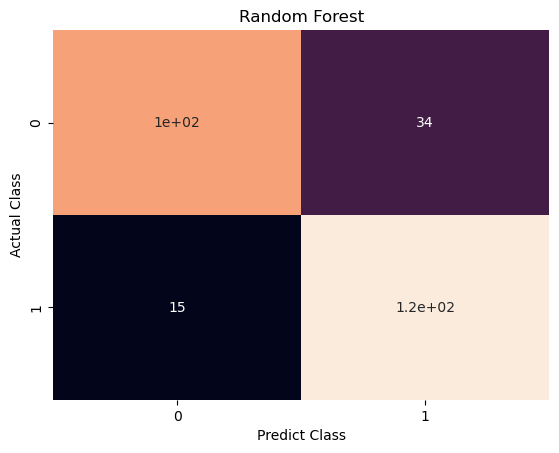

In [36]:
make_confusion_matrix("Random Forest", y_test_label, y_pred)